In [1]:
from binpack.models import Result
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statsmodels.stats import descriptivestats

In [2]:
results = Result.objects.filter(n_tiles=20, improved_sel=True)

In [3]:
results.values('score')

<QuerySet [{'score': 1.0}, {'score': 1.0}, {'score': 1.0}, {'score': 1.0}, {'score': 1.0}, {'score': 1.0}, {'score': 1.0}, {'score': 1.0}, {'score': 2.0}, {'score': 0.0}, {'score': 1.0}, {'score': 1.0}, {'score': 1.0}, {'score': 0.0}, {'score': 1.0}, {'score': 1.0}, {'score': 1.0}, {'score': 0.0}, {'score': 1.0}, {'score': 0.0}, '...(remaining elements truncated)...']>

In [4]:
def calc_p_value(results, max_depth_instances, avg_depth_instances, is_guillotine=True): 
    max_depth_wins = 0
    avg_depth_wins = 0
    draws = 0
    values = []
    for max_depth_res in max_depth_instances:
        if is_guillotine:
            kwargs = {'problem_id': max_depth_res.problem_id}
        else:
            kwargs = {'their_id': max_depth_res.their_id}
        kwargs['score__isnull'] =  False
        avg_depth_res = results.filter(
            strategy='avg_depth',
            **kwargs,
            )
        if avg_depth_res.count() == 1:
            avg_depth_score = avg_depth_res.first().score
            max_depth_score = max_depth_res.score
            if avg_depth_score > max_depth_score: # lower is better
                max_depth_wins +=1 
                values.append(1)
            elif avg_depth_score < max_depth_score:
                avg_depth_wins += 1
                values.append(-1)
            else:
                draws += 1
                
    print(f'In total max_depth_wins: {max_depth_wins}, avg_depth_wins: {avg_depth_wins}, and {draws} ties.')
    
    m = descriptivestats.sign_test(values)
    print(f'p value: {m[1]}')

In [23]:
'''
gets problem_id's of problems which were solved by all variations
'''
def get_best_problem_ids(N=1000, guillotine=True):
    ret = []
    common_args = {'improved_sel': True, 'score__isnull': False}
    problem_ids = set()
    for r in Result.objects.filter(n_simulations=5000, **common_args):
        if guillotine:
            common_args['problem_generator'] = 'guillotine'
            count = len(set(Result.objects.filter(problem_id=r.problem_id, **common_args).values_list('strategy', 'n_simulations')))
            problem_ids.add((r.problem_id, count))
        else:
            common_args['problem_generator'] = 'florian'
            count = len(set(Result.objects.filter(their_id=r.their_id, **common_args).values_list('strategy', 'n_simulations')))
            problem_ids.add((r.their_id, count))
            
    problem_ids = sorted(problem_ids, key=lambda x: x[1])
    N_COMBINATIONS = 12 # 100, 200, 500, 1k, 2k, 5k for avg and max depth
    ret =  [x[0] for x in problem_ids if x[1] == N_COMBINATIONS]
    return ret[:1000]

In [34]:
best_problem_ids = get_best_problem_ids()
best_their_ids = get_best_problem_ids(guillotine=False)

1447
1354


In [35]:
print(len(best_problem_ids))
print(len(best_their_ids))

1000
1000


In [36]:
common_args = {'problem_generator': 'florian', 'improved_sel': True}

N_SIM = [100, 200, 500, 1000, 2000, 5000]

# find same problem instances
for n_sim in N_SIM:
    print('*' * 50)
    print(f'SIMULATIONS: {n_sim}')
    print('*' * 50)
    common_args['problem_generator'] = 'guillotine'
    common_args['n_simulations'] = n_sim
    common_args['score__isnull'] = False

    g_max_depth_instances = Result.objects.filter(problem_id__in=best_problem_ids, strategy='max_depth', **common_args)
    g_avg_depth_instances = Result.objects.filter(problem_id__in=best_problem_ids, strategy='avg_depth', **common_args)

    print('Guillotine:')
    calc_p_value(Result.objects.filter(problem_id__in=best_problem_ids, **common_args), g_max_depth_instances, g_avg_depth_instances)

    common_args['problem_generator'] = 'florian'
    ng_avg_depth_instances = Result.objects.filter(strategy='avg_depth', their_id__in=best_their_ids,  **common_args)
    ng_max_depth_instances = Result.objects.filter(strategy='max_depth', their_id__in=best_their_ids, **common_args)
    ng_avg_depth_scores = ng_avg_depth_instances.values('score')
    ng_max_depth_scores = ng_max_depth_instances.values('score')

    print('Non-guillotine:')
    calc_p_value(Result.objects.filter(**common_args), ng_max_depth_instances, ng_avg_depth_instances, is_guillotine=False)

    # scores = results.values('score', 'strategy')
    # print(np.average(np.array(results.filter(score__isnull=False, strategy='avg_depth', **common_args).values_list('rows', flat=True))))
    # print(np.average(np.array(results.filter(score__isnull=False, strategy='max_depth', **common_args).values_list('rows', flat=True))))

**************************************************
SIMULATIONS: 100
**************************************************
Guillotine:
In total max_depth_wins: 142, avg_depth_wins: 251, and 607 ties.
p value: 4.206644249543032e-08
Non-guillotine:
In total max_depth_wins: 461, avg_depth_wins: 147, and 392 ties.
p value: 1.1721393347580135e-38
**************************************************
SIMULATIONS: 200
**************************************************
Guillotine:
In total max_depth_wins: 163, avg_depth_wins: 220, and 617 ties.
p value: 0.004157263558733446
Non-guillotine:
In total max_depth_wins: 519, avg_depth_wins: 127, and 354 ties.
p value: 4.058279577695039e-57
**************************************************
SIMULATIONS: 500
**************************************************
Guillotine:
In total max_depth_wins: 156, avg_depth_wins: 189, and 655 ties.
p value: 0.08477242786427612
Non-guillotine:
In total max_depth_wins: 574, avg_depth_wins: 103, and 323 ties.
p value: 3.89091

In [37]:
def score_to_int(df):
    df['score'] = df['score'].astype('int')
    return df

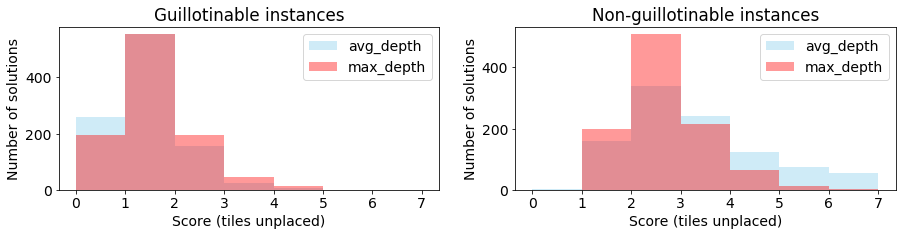

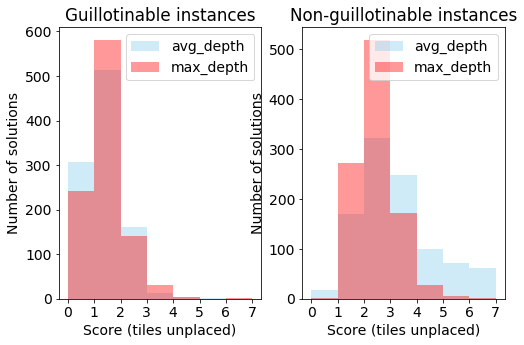

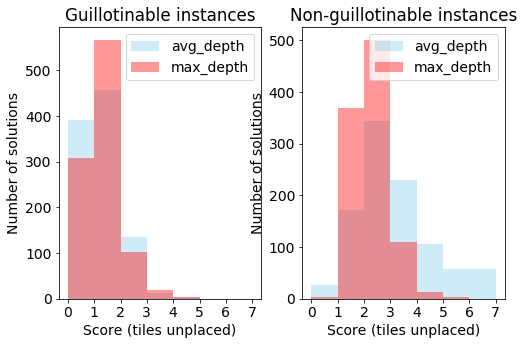

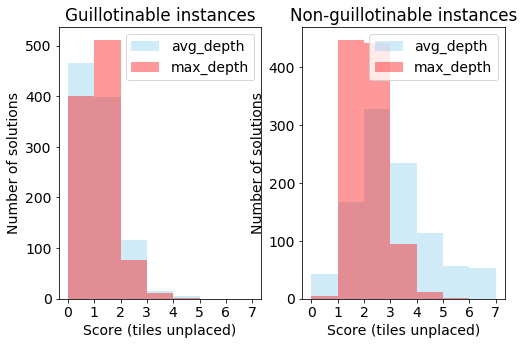

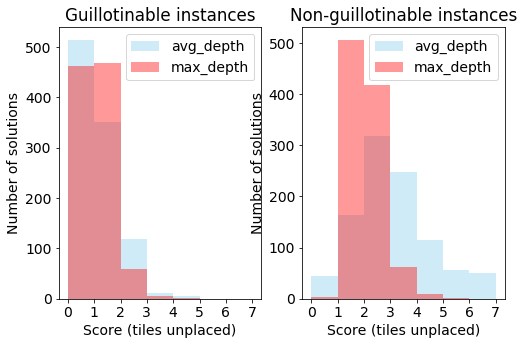

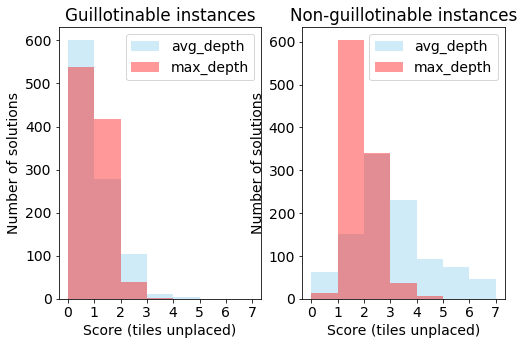

In [38]:
# scores_df
for n_sim in N_SIM:
    common_args = {
        'score__isnull': False, 'improved_sel': True,
        'n_simulations': n_sim
    }
    f, axes = plt.subplots(1, 2)
    bins = np.arange(0, 8)
    for i in range(2):
        if i == 0:
            common_args['problem_generator'] = 'guillotine'
            title = 'Guillotinable instances'
            avg_depth_scores = Result.objects.filter(problem_id__in=best_problem_ids, strategy='avg_depth', **common_args).values('score')
            max_depth_scores = Result.objects.filter(problem_id__in=best_problem_ids, strategy='max_depth', **common_args).values('score')
        else:
            title = 'Non-guillotinable instances'
            common_args['problem_generator'] = 'florian'
            avg_depth_scores = Result.objects.filter(their_id__in=best_their_ids, strategy='avg_depth', **common_args).values('score')
            max_depth_scores = Result.objects.filter(their_id__in=best_their_ids, strategy='max_depth', **common_args).values('score')

        sns.distplot(score_to_int(pd.DataFrame.from_records(avg_depth_scores)),
                     kde=False, color='skyblue', label='avg_depth', bins=bins, ax=axes[i])
        sns.distplot(score_to_int(pd.DataFrame.from_records(max_depth_scores)),
                          kde=False, color='red', label='max_depth', bins=bins, ax=axes[i])
        axes[i].xaxis.set_major_locator(ticker.MultipleLocator(1))
        axes[i].xaxis.set_major_formatter(ticker.ScalarFormatter())
        # plt.xlim(left=i)
        axes[i].set_ylabel('Number of solutions')
        axes[i].set_xlabel('Score (tiles unplaced)')
        axes[i].set_title(title)
        axes[i].legend()
    plt.rcParams["figure.figsize"] = (8,5)
    plt.show()

### Simulation runs vs score

100 1000
200 1000
500 1000
1000 1000
2000 1000
5000 1000
[0 1 2 3 4 5]
Number of tiles non-placed in correlation with simulation runs


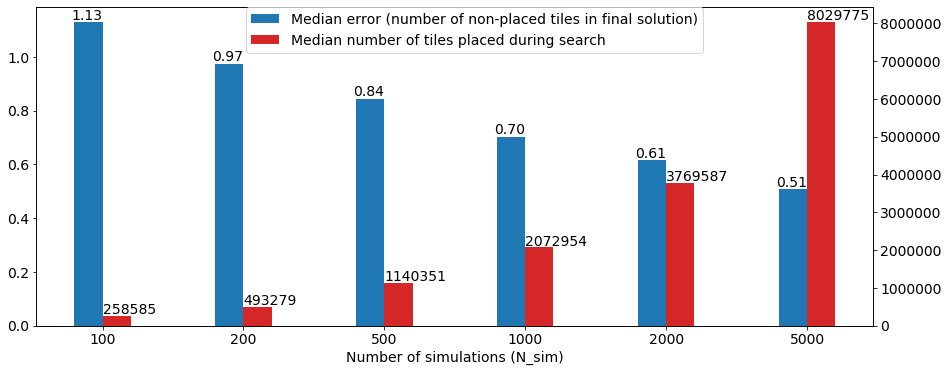

In [39]:
from collections import defaultdict, OrderedDict
from matplotlib.ticker import FuncFormatter, MaxNLocator
SIMULATION_RUNS = N_SIM
def format_fn(tick_val, tick_pos):
    if int(tick_val) in range(0, len(SIMULATION_RUNS)):
        return SIMULATION_RUNS[int(tick_val)]
    else:
        return ''
x_vals = defaultdict(list)
results = OrderedDict()

plt.rcParams["figure.figsize"] = (15,3)

for n_simulations in SIMULATION_RUNS:
    common_args = {
        'problem_id__in': best_problem_ids, 'strategy': 'max_depth', 'n_simulations': n_simulations,
        'improved_sel': True, 'score__isnull': False
    }
    avg_score = np.average(np.array(Result.objects.filter(
        **common_args).order_by('their_id').values_list('score', flat=True)))
    results[n_simulations] = {'median score': avg_score}
    avg_tiles = np.average(np.array(Result.objects.filter(
        **common_args).order_by('their_id').values_list('n_tiles_placed', flat=True)))
    print(n_simulations, Result.objects.filter(**common_args).count())
    results[n_simulations]['median tiles placed'] = avg_tiles
    
fig,  ax1 = plt.subplots()
x = np.arange(0, len(SIMULATION_RUNS) )
print(x)
y = np.arange(0,3)
width_offset = 0.10
width = 0.2 
for i, score_type in enumerate(['median score', 'median tiles placed']):
    # print(result)
    sc = [v[score_type] for k, v in results.items()]
    current_ax = ax1
    color = 'tab:blue'
    label = 'Median error (number of non-placed tiles in final solution)'
    if i == 1:
        color = 'tab:red'
        ax2 = ax1.twinx()
        current_ax = ax2
        width_offset = -width_offset
        label = 'Median number of tiles placed during search'
    current_ax.bar(x - width_offset, sc, width=width, 
            label=label, color=color)
    current_ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
    current_ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    for i, v in enumerate(sc): 
        offset = width_offset 
        text = '{:.2f}'.format(v)
        _offset = 0.12
        _offset_top = 0.01
        if v >  10:
            text = '{:.0f}'.format(v)
            _offset = 0.10
            _offset_top = 50000.35
        current_ax.text(x[i] - offset - _offset, v + _offset_top, text)
   
plt.rcParams["font.size"] = 14
# plt.yticks(ticks=np.arange(0, 4))
ax1.set_xlabel('Number of simulations (N_sim)')
# ax1.set_ylabel('Median error (number of non-placed tiles in final solution)')
# ax2.set_ylabel('Median number of tiles placed during search')
fig.legend(loc='upper center')
fig.subplots_adjust(top=1.6)
print('Number of tiles non-placed in correlation with simulation runs')
plt.show()

In [40]:
Result.objects.filter(n_simulations=2000).values('score', 'problem_id')


Result.objects.filter(n_simulations=1000).values('score', 'problem_id').filter(problem_id='eeca903e-157c-4f82-9c7f-ad75a41c6b1b')

<QuerySet []>

### Compare n_tiles

5 40 {'median score': 0.0}
6 40 {'median score': 0.0}
7 40 {'median score': 0.0}
8 40 {'median score': 0.0}
9 40 {'median score': 0.05}
10 40 {'median score': 0.125}
11 40 {'median score': 0.425}
12 40 {'median score': 0.45}
13 40 {'median score': 0.7}
14 40 {'median score': 0.875}
15 40 {'median score': 0.8}
16 40 {'median score': 1.675}
17 40 {'median score': 1.775}
18 40 {'median score': 1.375}
19 40 {'median score': 1.8}
20 40 {'median score': 1.05}
21 40 {'median score': 2.05}
22 40 {'median score': 1.925}
23 40 {'median score': 2.15}
24 40 {'median score': 2.15}
25 40 {'median score': 2.4}
26 40 {'median score': 3.5}
27 40 {'median score': 2.35}
28 40 {'median score': 2.475}
29 40 {'median score': 2.45}
30 40 {'median score': 2.725}
[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30]
Number of tiles non-placed in correlation with simulation runs


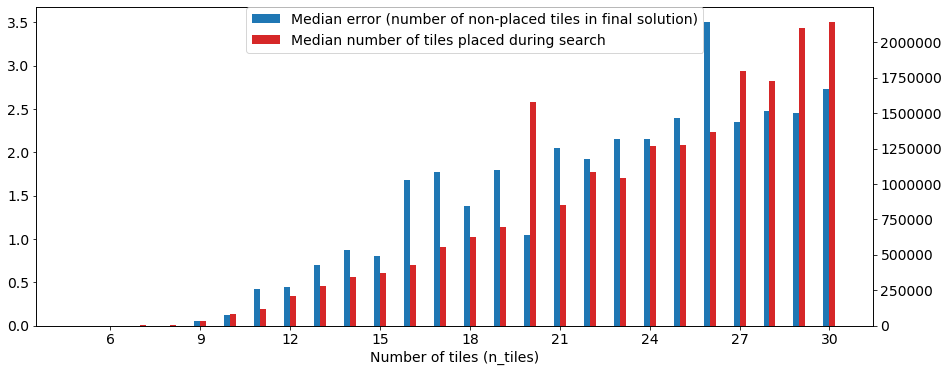

In [41]:
from collections import defaultdict, OrderedDict
from matplotlib.ticker import FuncFormatter, MaxNLocator

N_TILES = list(range(5, 31))

def format_fn(tick_val, tick_pos):
    return str(int(tick_val))
    if int(tick_val) in N_TILES:
        return N_TILES[int(tick_val)]
    else:
        return ''
    
x_vals = defaultdict(list)
results = OrderedDict()

plt.rcParams["figure.figsize"] = (15,3)

LAST_N_RECORDS = 40

for n_tiles in N_TILES:
    common_args = {
        'strategy': 'max_depth', 'n_tiles': n_tiles,
        'score__isnull': False, 'n_tiles_placed__isnull': False,
        'n_simulations': 1000, 'problem_generator': 'guillotine'
    }
    res_avg_score = Result.objects.filter(**common_args).order_by('-created_on').values_list('score', flat=True)[:LAST_N_RECORDS]
    if res_avg_score:
        avg_score = np.average(np.array(res_avg_score))
    else:
        avg_score = 0
    results[n_tiles] = {'median score': avg_score}
    
    res_tiles_placed = Result.objects.filter(**common_args).order_by('-created_on').values_list('n_tiles_placed', flat=True)[:LAST_N_RECORDS]
    if res_tiles_placed:
        avg_tiles = np.average(np.array(res_tiles_placed))
    else:
        avg_tiles = 0
    print(n_tiles, res_tiles_placed.count(), results[n_tiles])
    results[n_tiles]['median tiles placed'] = avg_tiles
    
fig,  ax1 = plt.subplots()
x = np.arange(N_TILES[0], N_TILES[-1] + 1)
print(x)
y = np.arange(0,3)
width_offset = 0.10
width = 0.2 
for i, score_type in enumerate(['median score', 'median tiles placed']):
    # print(result)
    sc = [v[score_type] for k, v in results.items()]
    current_ax = ax1
    color = 'tab:blue'
    label = 'Median error (number of non-placed tiles in final solution)'
    if i == 1:
        color = 'tab:red'
        ax2 = ax1.twinx()
        current_ax = ax2
        width_offset = -width_offset
        label = 'Median number of tiles placed during search'
    current_ax.bar(x - width_offset, sc, width=width, 
            label=label, color=color)
    current_ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
    current_ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # for i, v in enumerate(sc): 
    #     offset = width_offset 
    #     text = '{:.3f}'.format(v)
    #     _offset = 0.12
    #     _offset_top = 0.01
    #     if v >  10:
    #         text = '{:.0f}'.format(v)
    #         _offset = 0.10
    #         _offset_top = 50000.35
    #     current_ax.text(x[i] - offset - _offset, v + _offset_top, text)
   
plt.rcParams["font.size"] = 14
# plt.yticks(ticks=np.arange(0, 4))
ax1.set_xlabel('Number of tiles (n_tiles)')
# ax1.set_ylabel('Median error (number of non-placed tiles in final solution)')
# ax2.set_ylabel('Median number of tiles placed during search')
fig.legend(loc='upper center')
fig.subplots_adjust(top=1.6)
print('Number of tiles non-placed in correlation with simulation runs')
plt.show()

### Tiles placed (Huristic vs MCTS)

In [42]:
instances_where_solution_is_found = Result.objects.filter(solution_found=True, n_tiles=20, problem_generator='florian').values('n_tiles_placed', 'their_tiles_placed')
scores_df = pd.DataFrame.from_records(instances_where_solution_is_found)
scores_df

,n_tiles_placed,their_tiles_placed
0,1428425,6118
1,6167470,6118
2,3942386,3845
3,918972,6919
4,3191908,6919
...,...,...
234,14302436,75
235,14302436,75
236,858933,29007
237,962642,22


In [43]:
STRATEGIES = ['avg_depth', 'max_depth']
common_args = {
    'n_tiles': 20, 
    'score__isnull': False, 
    'improved_sel': True,
    'their_id__in': best_their_ids
}
for strategy in STRATEGIES:
    for n_sim in N_SIM:
        solutions_found = Result.objects.filter(
            solution_found=True, problem_generator='florian', n_simulations=n_sim, strategy=strategy, **common_args).count()
        solutions_not_found = Result.objects.filter(
             problem_generator='florian', n_simulations=n_sim, strategy=strategy, **common_args).count()
        tiles_placed = np.average(np.array(Result.objects.filter(problem_generator='florian', n_simulations=n_sim, strategy=strategy, **common_args).values_list('n_tiles_placed', flat=True)))
        print(f'Florian instances with {n_sim} simulations and strategy {strategy}:')
        print(f'solutions found: {solutions_found} / {solutions_not_found} = {solutions_found / solutions_not_found * 100} %')
        print(f'tiles placed: {tiles_placed}')
        print()

Florian instances with 100 simulations and strategy avg_depth:
solutions found: 3 / 1000 = 0.3 %
tiles placed: 260901.445

Florian instances with 200 simulations and strategy avg_depth:
solutions found: 18 / 1000 = 1.7999999999999998 %
tiles placed: 525225.486

Florian instances with 500 simulations and strategy avg_depth:
solutions found: 27 / 1000 = 2.7 %
tiles placed: 1320564.747

Florian instances with 1000 simulations and strategy avg_depth:
solutions found: 42 / 1000 = 4.2 %
tiles placed: 2638213.166

Florian instances with 2000 simulations and strategy avg_depth:
solutions found: 45 / 1000 = 4.5 %
tiles placed: 5276579.745

Florian instances with 5000 simulations and strategy avg_depth:
solutions found: 63 / 1000 = 6.3 %
tiles placed: 13005273.549

Florian instances with 100 simulations and strategy max_depth:
solutions found: 0 / 1000 = 0.0 %
tiles placed: 231380.981

Florian instances with 200 simulations and strategy max_depth:
solutions found: 2 / 1000 = 0.2 %
tiles placed: 

In [44]:
common_args = {
    'n_tiles': 20, 
    'score__isnull': False, 
    'improved_sel': True,
    'problem_id__in': best_problem_ids,
}

for strategy in STRATEGIES:
    for n_sim in N_SIM:
        print(f'Guillotine instances - {n_sim} - {strategy}:')
        solutions_found = Result.objects.filter(
            solution_found=True,  problem_generator='guillotine', n_simulations=n_sim, strategy=strategy, **common_args).count()
        solutions_not_found = Result.objects.filter(
            problem_generator='guillotine', n_simulations=n_sim, strategy=strategy, **common_args).count()
        tiles_placed = np.average(np.array(Result.objects.filter( problem_generator='guillotine', n_simulations=n_sim, strategy=strategy, **common_args).values_list('n_tiles_placed', flat=True)))
        
        print(f'solutions found: {solutions_found} / {solutions_not_found} = {solutions_found / solutions_not_found * 100} %')
        print(f'tiles placed: {tiles_placed}')
        print()

Guillotine instances - 100 - avg_depth:
solutions found: 259 / 1000 = 25.900000000000002 %
tiles placed: 252288.143

Guillotine instances - 200 - avg_depth:
solutions found: 308 / 1000 = 30.8 %
tiles placed: 482297.894

Guillotine instances - 500 - avg_depth:
solutions found: 392 / 1000 = 39.2 %
tiles placed: 1094463.692

Guillotine instances - 1000 - avg_depth:
solutions found: 465 / 1000 = 46.5 %
tiles placed: 1973287.967

Guillotine instances - 2000 - avg_depth:
solutions found: 514 / 1000 = 51.4 %
tiles placed: 3620930.175

Guillotine instances - 5000 - avg_depth:
solutions found: 601 / 1000 = 60.099999999999994 %
tiles placed: 7432258.737

Guillotine instances - 100 - max_depth:
solutions found: 195 / 1000 = 19.5 %
tiles placed: 258584.628

Guillotine instances - 200 - max_depth:
solutions found: 243 / 1000 = 24.3 %
tiles placed: 493279.254

Guillotine instances - 500 - max_depth:
solutions found: 308 / 1000 = 30.8 %
tiles placed: 1140350.514

Guillotine instances - 1000 - max_dep

In [45]:
common_args = {
    'n_tiles': 20, 
    'score__isnull': False, 
    'improved_sel': True,
    'problem_id__in': best_problem_ids,
}
for strategy in STRATEGIES:
    for n_sim in N_SIM:
        average_tiles_placed_deterministic = Result.objects.filter(
            n_tiles=20, problem_generator='florian').aggregate(Avg('their_tiles_placed'))
        print('NG instances'); print('-' * 20)

        print('Florian tiles placed:', average_tiles_placed_deterministic)
        average_tiles_placed_deterministic = Result.objects.filter(
            n_tiles=20, problem_generator='florian', n_tiles_placed__isnull=False, strategy='max_depth').aggregate(Avg('n_tiles_placed'))
        print('MCTS tiles placed:', average_tiles_placed_deterministic); print()

        print('G instances'); print('-' * 20)
        average_tiles_placed_deterministic = Result.objects.filter(
            n_tiles=20, problem_generator='guillotine', n_tiles_placed__isnull=False, strategy='max_depth').aggregate(Avg('n_tiles_placed'))
        print('MCTS tiles placed:', average_tiles_placed_deterministic)

NG instances
--------------------
Florian tiles placed: {'their_tiles_placed__avg': 254973310.72964478}
MCTS tiles placed: {'n_tiles_placed__avg': 3529233.6111227483}

G instances
--------------------
MCTS tiles placed: {'n_tiles_placed__avg': 2107076.716373618}
NG instances
--------------------
Florian tiles placed: {'their_tiles_placed__avg': 254973310.72964478}
MCTS tiles placed: {'n_tiles_placed__avg': 3529233.6111227483}

G instances
--------------------
MCTS tiles placed: {'n_tiles_placed__avg': 2107076.716373618}
NG instances
--------------------
Florian tiles placed: {'their_tiles_placed__avg': 254973310.72964478}
MCTS tiles placed: {'n_tiles_placed__avg': 3529233.6111227483}

G instances
--------------------
MCTS tiles placed: {'n_tiles_placed__avg': 2107076.716373618}
NG instances
--------------------
Florian tiles placed: {'their_tiles_placed__avg': 254973310.72964478}
MCTS tiles placed: {'n_tiles_placed__avg': 3529233.6111227483}

G instances
--------------------
MCTS tiles